In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings;warnings.filterwarnings('ignore')
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')

from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  LabelEncoder
from sklearn.ensemble import VotingRegressor
import optuna

In [2]:
train_path = './train.csv'
test_path  = './test.csv'
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [3]:
train['is_test'] = 0
test['is_test'] = 1
concat = pd.concat([train, test])

# 기준금리 추가하기

In [4]:
base_rate_path  = './기준금리.csv'
base_rate_df = pd.read_csv(base_rate_path)

In [5]:
# 월일 변수를 월과 일로 나누어주고 년 월 일을 합쳐 날짜를 8자리 정수로 표현하기
base_rate_df['년'] = base_rate_df['년'].map(lambda x: str(x))
base_rate_df['월'] = base_rate_df['월일'].map(lambda x : x[:2])
base_rate_df['일'] = base_rate_df['월일'].map(lambda x : x[4:6])
base_rate_df['날짜'] = base_rate_df['년'] + base_rate_df['월'] + base_rate_df['일']
base_rate_df['날짜'] = base_rate_df['날짜'].map(lambda x: int(x))
base_rate_df = base_rate_df[['날짜', '기준금리']]

In [6]:
# concat에 계약년월과 계약일을 합쳐 계약날짜 변수 생성 (8자리 정수)
concat['계약날짜'] = concat['계약년월'] * 100 + concat['계약일']

In [7]:
# concat의 '계약날짜' 값에 따라 '기준금리'를 반환해주는 함수.
def date_to_rate(date):
    for i in range(54, 0, -1): # 기준금리 데이터의 마지막 인덱스(54)에서 하나씩 올라가며 날짜를 비교하면서 기준금리 확인
        if date >= base_rate_df['날짜'][i] and date <base_rate_df['날짜'][i - 1]:
            return base_rate_df['기준금리'][i]
    return base_rate_df['기준금리'][0] # 날짜(date)가 기준금리 데이터의 가장 최신 날짜보다 같거나 크다면 가장 최신 기준금리 반환

# 예:
# date_to_rate(20211126)
# 1.0

In [8]:
# concat_new에 기준금리 변수 추가
concat['기준금리'] = concat['계약날짜'].apply(date_to_rate)

In [9]:
# '기준금리'열의 데이터 형식을 float로 변경
concat['기준금리'] = concat['기준금리'].astype(float)

In [10]:
# 추가된 변수 확인
concat[['계약날짜', '기준금리']]

,계약날짜,기준금리
0,20171208,1.5
1,20171222,1.5
2,20171228,1.5
3,20180103,1.5
4,20180108,1.5
...,...,...
9267,20230719,3.5
9268,20230725,3.5
9269,20230827,3.5
9270,20230902,3.5


# 전세가격지수 추가하기

In [11]:
jeonsae_path  = './아파트전세가격지수.csv'
jeonsae_df = pd.read_csv(jeonsae_path, encoding='cp949')

In [12]:
# 전세가격지수 데이터를 '년월'과 서울의 '전세가격지수'를 열로 가지는 데이터로 변환
data = {'년월':list(jeonsae_df.columns[1:]), '전세가격지수':list(jeonsae_df.iloc[1])[1:]}
seoul_jeonsae_df = pd.DataFrame(data)
seoul_jeonsae_df.head()

,년월,전세가격지수
0,2003.11,46.7
1,2003.12,46.2
2,2004.01,46.0
3,2004.02,46.3
4,2004.03,46.5


In [13]:
# 전세가격지수 데이터의 '년월' 형식을 concat의 '계약년월' 형식과 통일
seoul_jeonsae_df['년월'] = seoul_jeonsae_df['년월'].map(lambda x : int(x.split('.')[0]) * 100 + int(x.split('.')[1]))

In [14]:
# '전세가격지수' 변수가 추가된 concat 데이터
concat = pd.merge(concat, seoul_jeonsae_df, left_on='계약년월', right_on='년월', how='inner').drop('년월', axis=1)

In [15]:
# concat의 '전세가격지수'열의 형식을 float 변경
concat['전세가격지수'] = concat['전세가격지수'].astype(float)

In [16]:
# 확인을 위해 concat에서 랜덤으로 10개 샘플 뽑아보기
concat[['계약년월', '전세가격지수']].sample(n=10)

,계약년월,전세가격지수
859864,201305,70.8
955876,201102,63.2
125136,201203,69.1
641780,201601,88.4
173258,200907,53.8
1115959,200709,53.6
631174,201607,89.5
809808,201312,75.5
1661,201712,92.7
1044323,200710,53.7


# 인구밀도 추가

In [17]:
population_density_path  = './인구밀도.csv'
population_density = pd.read_csv(population_density_path)

In [18]:
# 맨 위 row를 변수 이름으로 설정
population_density.columns = population_density.iloc[0]
population_density = population_density[1:]
population_density.head()

,동별(1),동별(2),동별(3),인구 (명),면적 (㎢),인구밀도 (명/㎢)
1,합계,소계,소계,9667669,605.21,15974
2,합계,종로구,소계,152211,23.91,6365
3,합계,종로구,사직동,9355,1.23,7606
4,합계,종로구,삼청동,2642,1.49,1773
5,합계,종로구,부암동,9536,2.27,4201


In [19]:
# concat의 '시군구' 변수에서 동을 분리하여 따로 변수 만들기
concat['동'] = concat['시군구'].map(lambda x : x.split()[2])

In [20]:
# 인구밀도 데이터 변수의 타입 변환
population_density_new = population_density[['동별(3)', '인구 (명)', '면적 (㎢)', '인구밀도 (명/㎢)']]
population_density_new['인구 (명)'] = population_density_new['인구 (명)'].astype(float)
population_density_new['면적 (㎢)'] = population_density_new['면적 (㎢)'].astype(float)
population_density_new['인구밀도 (명/㎢)'] = population_density_new['인구밀도 (명/㎢)'].astype(float)

In [21]:
# concat에서 동을 (유사)행정동으로 반환하는 함수
# '동'이 여러 행정동에 걸쳐있는 경우 임으로 걸쳐있는 행정동 중 하나로 선택하였음
def to_hangjungdong(dong):
    if dong in ['금호동1가']: 
        return '금호1가동'
    elif dong in ['봉천동']: # 중앙동은 5개의 동에 걸쳐있음
        return '중앙동'
    elif dong in ['마곡동']: # 마곡동은 가양1동, 방화1동, 발산1동에 걸쳐있음
        return '가양동'
    elif dong in ['내발산동']: # 내발산동은 '발산1동'과 '우장산동'에 걸쳐있음
        return '발산1동'
    elif dong in ['자곡동', '율현동']:
        return '세곡동'
    elif dong in ['금호동2가', '금호동3가']:
        return '금호2.3가동'
    elif dong in ['금호동4가']:
        return '금호4가동'
    elif dong in ['남대문로5가']:
        return '회현동'
    elif dong in ['남산동2가']:
        return '명동'
    elif dong in ['당산동1가', '당산동2가', '당산동3가']:
        return '당산1동'
    elif dong in ['당산동4가', '당산동5가', '당산동6가']:
        return '당산2동'
    elif dong in ['동선동1가', '동선동3가', '동선동4가', '동선동5가', '동소문동6가', '동소문동7가']:
        return '동선동'
    elif dong in ['동소문동5가', '삼선동2가', '삼선동3가', '삼선동4가', '삼선동5가']:
        return '삼선동'
    elif dong in ['만리동2가', '만리동1가']:
        return '중림동'
    elif dong in ['명륜1가', '명륜2가', '명륜3가']:
        return '혜화동'
    elif dong in ['문래동2가', '문래동3가', '문래동4가', '문래동5가', '문래동6가']:
        return '문래동'
    elif dong in ['보문동2가', '보문동3가', '보문동4가', '보문동6가']:
        return '보문동'
    elif dong in ['성북동1가', '동소문동', '동소문동4가']:
        return '성북동'
    elif dong in ['신문로1가', '신문로2가', '내수동', '당주동', '필운동']:
        return '사직동'
    elif dong in ['안암동1가', '안암동3가', '안암동4가', '안암동5가']:
        return '안암동'
    elif dong in ['양평동1가', '양평동2가', '양평동3가']: 
        return '양평1동'
    elif dong in ['양평동4가', '양평동5가', '양평동6가']: # '양평동3가'는 '양평1동'과 '양평2동'에 걸쳐있음 
        return '양평2동'
    elif dong in ['영등포동1가', '영등포동2가', '영등포동3가', '영등포동4가', '영등포동5가', '영등포동7가', '영등포동8가']:
        return '영등포동'
    elif dong in ['용산동2가']:
        return '용산2가동'
    elif dong in ['원효로1가', '원효로2가', '문배동', '신계동']: # 원효로1동, 2동의 인구밀도가 크게 차이나기 떄문에 두 개 분리
        return  '원효로1동'
    elif dong in ['원효로3가', '원효로4가', '산천동', '신창동', '청암동']:
        return '원효로2동'
    elif dong in ['을지로5가', '산림동', '입정동']:
        return '을지로동'
    elif dong in ['인현동2가', '오장동', '충무로4가', '충무로5가']: 
        return '광희동'
    elif dong in ['장충동1가', '장충동2가']:
        return '장충동'
    elif dong in ['청파동1가', '청파동3가']:
        return '청파동'
    elif dong in ['충정로2가', '충정로3가', '합동', '미근동']:
        return '충현동'
    elif dong in ['필동1가', '필동3가', '묵정동', '예장동']:
        return '필동'
    elif dong in ['한강로1가', '한강로2가', '한강로3가', '용산동5가']:
        return '한강로동'
    elif dong in ['회현동1가', '회현동2가', '남창동']:
        return '회현동'
    elif dong in ['천왕동']:
        return '오류동'
    elif dong in ['온수동', '궁동']:
        return '수궁동'
    elif dong in ['용두동', '신설동']:
        return '용신동'
    elif dong in ['본동']:
        return '노량진동'
    elif dong in ['동작동']:
        return '사당동'
    elif dong in ['노고산동']:
        return '대흥동'
    elif dong in ['마포동']:
        return '도화동'
    elif dong in ['상수동']:
        return '서강동'
    elif dong in ['신공덕동']:
        return '공덕동'
    elif dong in ['동교동']:
        return '연남동'
    elif dong in ['중동']:
        return '성산동'
    elif dong in ['창전동', '하중동']:
        return '서강동'
    elif dong in ['냉천동', '영천동', '현저동']:
        return '천연동'
    elif dong in ['토정동']:
        return '용강동'
    elif dong in ['현석동', '구수동']:
        return '신수동'
    elif dong in ['대현동', '창천동']:
        return '신촌동'
    elif dong in ['우면동']:
        return '양재동'
    elif dong in ['도선동', '상왕십리동', '하왕십리동', '홍익동']:
        return '왕십리도선동'
    elif dong in ['상월곡동', '하월곡동']:
        return '월곡동'
    elif dong in ['신천동']:
        return '잠실동'
    elif dong in ['여의도동']:
        return '여의동'
    elif dong in ['갈월동', '동자동']:
        return '남영동'
    elif dong in ['도원동']:
        return '용문동'
    elif dong in ['동빙고동', '주성동']:
        return '서빙고동'
    elif dong in ['익선동', '견지동', '인의동', '수송동', '원남동', '낙원동']:
        return '종로1.2.3.4가동'
    elif dong in ['효제동', '충신동', '연지동']:
        return '종로5.6가동'
    elif dong in ['교북동', '행촌동', '홍파동', '평동']:
        return '교남동'
    elif dong in ['누상동', '옥인동', '청운동', '통인동', '신교동']:
        return '청운효자동'
    elif dong in ['동숭동', '연건동']:
        return '이화동'
    elif dong in ['신영동']:
        return '부암동'
    elif dong in ['순화동', '정동']:
        return '소공동'
    elif dong in ['흥인동']:
        return '신당동'
    elif dong in ['구기동']:
        return '평창동'
    else:
        return dong
    

In [22]:
# concat의 '동'을 유사 행정동으로 변환
concat['동'] = concat['동'].apply(to_hangjungdong)

In [23]:
# 인구밀도 데이터의 몇 개의 행정동을 하나로 합쳐주기 위한 리스트
dong_merge_list = [['성수동1가', '성수1가1동','성수1가2동'],
                   ['성수동2가', '성수2가1동', '성수2가3동'],
                   ['논현동', '논현1동', '논현2동'],
                   ['대치동', '대치1동', '대치2동', '대치4동'],
                   ['도곡동', '도곡1동', '도곡2동'],
                   ['역삼동', '역삼1동', '역삼2동'],
                   ['일원동', '일원본동', '일원1동'],
                   ['고덕동', '고덕1동', '고덕2동'],
                   ['둔촌동', '둔촌1동', '둔촌2동'],
                   ['명일동', '명일1동', '명일2동'],
                   ['상일동', '상일1동', '상일2동'],
                   ['성내동', '성내1동', '성내2동', '성내3동'],
                   ['암사동', '암사1동', '암사2동', '암사3동'],
                   ['천호동', '천호1동', '천호2동', '천호3동'],
                   ['번동', '번1동', '번2동', '번3동'],
                   ['가양동', '가양1동', '가양2동', '가양3동'],
                   ['수유동', '수유1동', '수유2동', '수유3동'],
                   ['등촌동', '등촌1동', '등촌2동', '등촌3동'],
                   ['방화동', '방화1동', '방화2동', '방화3동'],
                   ['화곡동', '화곡1동', '화곡2동',  '화곡3동', '화곡4동', '화곡6동', '화곡8동', '화곡본동'],
                   ['구의동', '구의1동', '구의2동', '구의3동'],
                   ['자양동', '자양1동', '자양2동', '자양3동', '자양4동'],
                   ['개봉동', '개봉1동', '개봉2동', '개봉3동'],
                   ['고척동', '고척1동', '고척2동'],
                   ['중곡동', '중곡1동', '중곡2동', '중곡3동'],
                   ['구로동', '구로1동', '구로2동', '구로3동', '구로4동', '구로5동'],
                   ['개포동', '개포1동', '개포2동', '개포3동', '개포4동'],
                   ['오류동', '오류1동', '오류2동'],
                   ['독산동', '독산1동', '독산2동', '독산3동', '독산4동'],
                   ['시흥동', '시흥1동', '시흥2동', '시흥3동', '시흥4동', '시흥5동'],
                   ['공릉동', '공릉1동', '공릉2동'],
                   ['상계동', '상계1동', '상계2동', '상계5동', '상계8동', '상계9동', '상계10동', '상계3.4동', '상계6.7동'],
                   ['월계동', '월계1동', '월계2동', '월계3동'],
                   ['중계동', '중계본동', '중계1동', '중계4동', '중계2.3동'],
                   ['하계동', '하계1동', '하계2동'],
                   ['도봉동', '도봉1동', '도봉2동'],
                   ['방학동', '방학1동', '방학2동', '방학3동'],
                   ['쌍문동', '쌍문1동', '쌍문2동', '쌍문3동', '쌍문4동'],
                   ['창동', '창1동', '창2동', '창3동', '창4동', '창5동'],
                   ['답십리동', '답십리1동', '답십리2동'],
                   ['이문동', '이문1동', '이문2동'],
                   ['장안동', '장안1동', '장안2동'],
                   ['전농동', '전농1동', '전농2동'],
                   ['휘경동', '휘경1동', '휘경2동'],
                   ['노량진동', '노량진1동', '노량진2동'],
                   ['사당동', '사당1동', '사당2동', '사당3동', '사당4동', '사당5동'],
                   ['상도동', '상도1동', '상도2동', '상도3동', '상도4동'],
                   ['신대방동', '신대방1동', '신대방2동'],
                   ['성산동', '성산1동', '성산2동'],
                   ['신정동', '신정1동', '신정2동', '신정3동', '신정4동', '신정6동', '신정7동'],
                   ['망원동', '망원1동', '망원2동'],
                   ['남가좌동', '남가좌1동', '남가좌2동'],
                   ['북가좌동', '북가좌1동', '북가좌2동'],
                   ['홍은동', '홍은1동', '홍은2동'],
                   ['홍제동', '홍제1동', '홍제2동', '홍제3동'],
                   ['반포동', '반포본동', '반포1동', '반포2동', '반포3동', '반포4동'],
                   ['방배동', '방배본동', '방배1동', '방배2동', '방배3동', '방배4동'],
                   ['서초동', '서초1동', '서초2동', '서초3동', '서초4동'],
                   ['양재동', '양재1동', '양재2동'],
                   ['행당동', '행당1동', '행당2동'],
                   ['길음동', '길음1동', '길음2동'],
                   ['돈암동', '돈암1동', '돈암2동'],
                   ['장위동', '장위1동', '장위2동', '장위3동'],
                   ['정릉동', '정릉1동', '정릉2동', '정릉3동', '정릉4동'],
                   ['가락동', '가락본동', '가락1동', '가락2동'],
                   ['거여동', '거여1동', '거여2동'],
                   ['마천동', '마천1동', '마천2동'],
                   ['문정동', '문정1동', '문정2동'],
                   ['송파동', '송파1동', '송파2동'],
                   ['방이동',  '방이1동', '방이2동'],
                   ['잠실동', '잠실본동', '잠실2동', '잠실3동', '잠실4동', '잠실6동', '잠실7동'],
                   ['풍납동', '풍납1동', '풍납2동'],
                   ['목동', '목1동', '목2동', '목3동', '목4동'],
                   ['신월동', '신월1동', '신월2동', '신월3동', '신월4동', '신월5동', '신월6동', '신월7동'],
                   ['당산동', '당산1동', '당산2동'],
                   ['대림동', '대림1동', '대림2동', '대림3동'],
                   ['신길동', '신길1동', '신길3동', '신길4동', '신길5동', '신길6동', '신길7동'],
                   ['이촌동', '이촌1동', '이촌2동'],
                   ['이태원동', '이태원1동', '이태원2동'],
                   ['불광동', '불광1동', '불광2동'],
                   ['갈현동', '갈현1동', '갈현2동'],
                   ['응암동', '응암1동', '응암2동', '응암3동'],
                   ['숭인동', '숭인1동', '숭인2동'],
                   ['창신동', '창신1동', '창신2동', '창신3동'],
                   ['망우동', '망우본동', '망우3동'],
                   ['면목동', '면목본동', '면목2동', '면목4동', '면목5동', '면목7동', '면목3.8동'],
                   ['묵동', '묵1동', '묵2동'],
                   ['상봉동', '상봉1동', '상봉2동'],
                   ['신내동', '신내1동', '신내2동'],
                   ['중화동', '중화1동', '중화2동'],
                   ['월곡동', '월곡1동', '월곡2동']
                   ]

In [24]:
# 행정동을 합쳐 유사 행정동을 구하고 합친 인구와 면적을 사용하여 밀도를 다시 구하기
for dongs in dong_merge_list:
    dong_dict ={}
    dong_dict['동별(3)'] = dongs[0]
    dong_pop = 0
    dong_area = 0
    for dong in dongs[1:]:
        dong_pop += population_density_new.loc[population_density_new['동별(3)'] == dong, '인구 (명)'].values[0]
        dong_area += population_density_new.loc[population_density_new['동별(3)'] == dong, '면적 (㎢)'].values[0]
    dong_density = dong_pop / dong_area
    dong_dict['인구 (명)'] = dong_pop
    dong_dict['면적 (㎢)'] = dong_area
    dong_dict['인구밀도 (명/㎢)'] = dong_density
    population_density_new = population_density_new.append(dong_dict, ignore_index=True)
    

In [25]:
# '인구밀도 (명/㎢)' 변수가 추가된 concat 데이터
concat = pd.merge(concat, population_density_new, left_on='동', right_on='동별(3)', how='inner').drop(['동별(3)', '인구 (명)', '면적 (㎢)'], axis=1)

In [26]:
# 확인을 위해 concat에서 랜덤으로 10개 샘플 뽑아보기
concat[['동', '인구밀도 (명/㎢)']].sample(n=10)

,동,인구밀도 (명/㎢)
189660,등촌동,31860.000000
1104248,묵동,28325.133690
796238,옥수동,13321.000000
720929,반포동,15277.759473
513278,창동,27660.235294
54793,신사동,38623.000000
442036,월계동,18039.812646
445917,중계동,19837.500000
415411,상계동,12722.130102
680039,용강동,25936.000000


# 서울시 공동주택 아파트 데이터로 결측치 채우기

In [27]:
concat['등기신청일자'] = concat['등기신청일자'].replace(' ', np.nan)
concat['거래유형'] = concat['거래유형'].replace('-', np.nan)
concat['중개사소재지'] = concat['중개사소재지'].replace('-', np.nan)

In [28]:
house_df_path = "./서울시 공동주택 아파트 정보.csv"
house_df = pd.read_csv(house_df_path, encoding='cp949')

In [29]:
# '도로명주소'을 기준으로 df_train의 결측치 ('아파트명'은 같은 아파트임에도 서로 일치하지 않는 항목이 많아서)
house_df['도로명주소'] = house_df['주소(도로명)'] + ' ' + house_df['주소(도로상세주소)']
house_df = house_df.drop_duplicates(subset='도로명주소')

In [30]:
# house_df_unique에서 '도로명주소'가 같은 경우 수치형인 열은 평균값으로, 범주형인 열은 최빈값으로 중복값 대체
def handle_duplicates(df):
    duplicates = df.duplicated(subset=['도로명주소'])
    for col in df.columns:
        if col != '도로명주소':
            if df[col].dtype == 'int64':
                df[col] = df.groupby('도로명주소')[col].transform(lambda x: x.mean() if not x.isnull().all() else x)
            else:
                df[col] = df.groupby('도로명주소')[col].transform(lambda x: x.mode().iloc[0] if not x.isnull().all() else x)
    df = df.drop_duplicates(subset=['도로명주소'])
    return df

house_df = handle_duplicates(house_df)

In [31]:
# concat과 house_df_unique에 공통으로 존재하는 열 찾기
common_cols = []
for col_1 in (concat.columns):
    for col_2 in list(list(house_df.columns)):
        if col_1 == col_2:
            common_cols.append(col_1)
            break

In [32]:
# concat의 결측치를 house_df_unique로 채우기
for col in common_cols:
    concat[col] = concat[col].fillna(concat['도로명'].map(house_df.set_index('도로명주소')[col]))
concat['아파트명'] = concat['아파트명'].fillna(concat['도로명'].map(house_df.set_index('도로명주소')['k-아파트명']))

# '아파트명' 변수의 값을 단순화하기

In [33]:
concat['아파트명'].isnull().sum()

2148

In [34]:
concat['아파트명'] = concat['아파트명'].fillna('others')

In [35]:
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
apt_names_list = top10 + apt_names

concat['transformed'] = False
for a in tqdm(apt_names_list):
    concat.loc[concat['아파트명'].str.contains(a), '아파트명'] = a
    concat.loc[concat['아파트명'].str.contains(a), 'transformed'] = True

for a in tqdm(apt_names):
    concat.loc[~concat['transformed'], '아파트명'] = 'others'

  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:00<00:00, 132.05it/s]


# 'k-건설사(시공사)' 변수의 값을 단순화하기

In [36]:
# # 아파트명 변수의 값을 단순화하기
concat['k-건설사(시공사)'] = concat['k-건설사(시공사)'].astype(str)
# 여러 건설사가 같이 시공하였을 시 더 브랜드 평판이 높은 건설사 혹은 데이터가 더 많은 건설사로 대체
def simple_apt(apt):
    if '현대건설' in apt or '힐스테이트' in apt:
        return '현대건설'
    elif '삼성물산' in apt:
        return '삼성물산'
    elif '대우건설' in apt or '푸르지오' in apt:
        return '대우건설'
    elif 'GS' in apt or 'gs' in apt or '지에스' in apt:
        return 'GS건설'
    elif '포스코' in apt:
        return '포스코건설'
    elif '래미안' in apt or '삼성물산' in apt:
        return '삼성물산'
    elif 'DL' in apt:
        return 'DL E&C'
    elif '롯데건설' in apt or '롯데캐슬' in apt:
        return '롯데건설'
    elif '현대산업' in apt:
        return '현대산업개발'
    elif '한화' in apt:
        return '한화건설'
    elif '쌍용' in apt:
        return '쌍용건설'
    elif apt in ['대한주택공사', 'LH공사', '한국토지주택공사', '한국주택공사', 'LH']:
        return '한국토지주택공사'
    elif '우성' in apt:
        return '우성건설'
    elif '한신' in apt:
        return '한신공영'
    elif '두산건설' in apt:
        return '두산건설'
    elif apt in ['동아건설', '(주)동아건설', '동아건설산업(주)', '동아건설산업', '동아건설(주)', '(주)동아건설산업', '동아,효성', '동아주택']:
        return '동아건설'
    elif '대림산업' in apt:
        return '대림산업'
    elif '벽산건설' in apt:
        return '벽산건설'
    elif '동부건설' in apt:
        return '동부건설'
    else:
        return 'Other'
    
    
concat['k-건설사(시공사)'] = concat['k-건설사(시공사)'].apply(simple_apt)
concat['k-건설사(시공사)'] = concat['k-건설사(시공사)'].fillna(value='Other') # 결측치도 'Other'로 통일

# 계약년 변수 추가

In [37]:
concat['계약년'] = concat['계약년월'].astype('str').map(lambda x : x[:4])

In [38]:
concat['계약년'] = concat['계약년'].astype(int)

# 아파트 연식 변수 추가

In [39]:
concat['연식(거래일기준)'] = concat['계약년'] - concat['건축년도']

In [40]:
concat['연식(23년기준)'] = 2023 - concat['건축년도']

In [41]:
# 연식(0 - 10, 11 - 30, > 30)별 변수 추가
concat['연식0-10'] = 0
concat.loc[concat['연식(23년기준)'] <= 10, '연식0-10'] = 1

concat['연식11-30'] = 0
concat.loc[(concat['연식(23년기준)'] > 10) & (concat['연식(23년기준)'] <= 30), '연식11-30'] = 1

concat['연식>30'] = 0
concat.loc[concat['연식(23년기준)'] > 30, '연식>30'] = 1

concat['연식(category)'] = 0
concat.loc[concat['연식0-10'] == 1, '연식(category)'] = '0'
concat.loc[concat['연식11-30'] == 1, '연식(category)'] = '1'
concat.loc[concat['연식>30'] == 1, '연식(category)'] = '2'

In [42]:
concat[['연식(23년기준)', '연식0-10', '연식11-30', '연식>30']].sample(n=10)

,연식(23년기준),연식0-10,연식11-30,연식>30
843517,25,0,1,0
751578,20,0,1,0
524173,31,0,0,1
1032248,12,0,1,0
578755,12,0,1,0
1928,31,0,0,1
165649,24,0,1,0
877791,41,0,0,1
593288,30,0,1,0
370921,24,0,1,0


<Axes: xlabel='연식(category)', ylabel='target'>

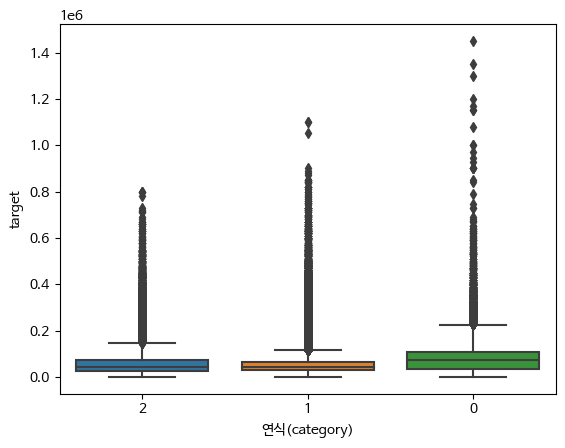

In [43]:
sns.boxplot(x='연식(category)', y='target', data=concat[:1118822])

# 세대별주차대수 변수 추가

In [44]:
concat['세대별주차대수'] = concat['주차대수']/concat['k-전체세대수']

<Axes: xlabel='연식(category)', ylabel='세대별주차대수'>

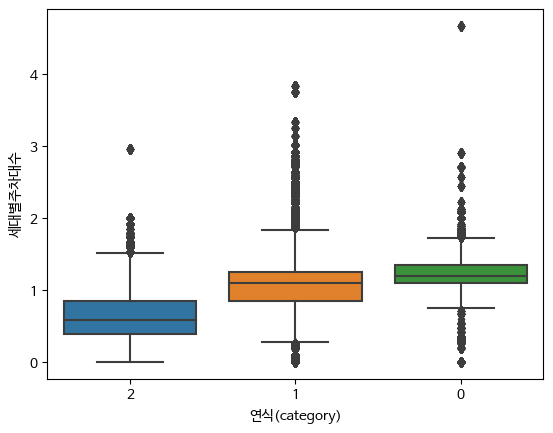

In [45]:
sns.boxplot(x='연식(category)', y='세대별주차대수', data=concat[:1118822])

In [46]:
concat['세대별주차대수'].isnull().sum()

261695

In [47]:
# 세대별주차대수의 결측치는 연식(category)을 기준으로 평균값을 채워넣는다.
concat['세대별주차대수'] = concat.groupby('연식(category)')['세대별주차대수'].transform(lambda x: x.fillna(x.mean()))

# X좌표 형시 str에서 float로 변환

In [48]:
concat['좌표X'] = concat['좌표X'].astype(float)

# '시군구' 변수에서 '구' 변수 분리하여 추가

In [49]:
concat['구'] = concat['시군구'].map(lambda x : x.split()[1])

# 변수 선택

In [50]:
concat_new = concat[['계약날짜','전세가격지수', '기준금리', '구','동', 'k-건설사(시공사)', '건축년도', '인구밀도 (명/㎢)', '전용면적(㎡)', '층',
                     '좌표X', '좌표Y', '아파트명','세대별주차대수', '연식(거래일기준)','target', 'is_test']]

# 테스트셋 분리

In [51]:
# 이제 다시 train과 test dataset을 분할해줍니다. 위에서 제작해 놓았던 is_test 칼럼을 이용합니다.
dt_train = concat_new.query('is_test==0')
dt_test = concat_new.query('is_test==1')

# 이제 is_test 칼럼은 drop해줍니다.
dt_train.drop(['is_test'], axis = 1, inplace=True)
dt_test.drop(['is_test'], axis = 1, inplace=True)
print(dt_train.shape, dt_test.shape)

(1124347, 16) (9294, 16)


In [52]:
continuous_columns = []
categorical_columns = []

for column in dt_train.columns:
    if pd.api.types.is_numeric_dtype(dt_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)


print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['계약날짜', '전세가격지수', '기준금리', '건축년도', '인구밀도 (명/㎢)', '전용면적(㎡)', '층', '좌표X', '좌표Y', '세대별주차대수', '연식(거래일기준)', 'target']
범주형 변수: ['구', '동', 'k-건설사(시공사)', '아파트명']


In [53]:
dt_test = dt_test.drop(columns = ['target'])

# 아웃라이어 확인

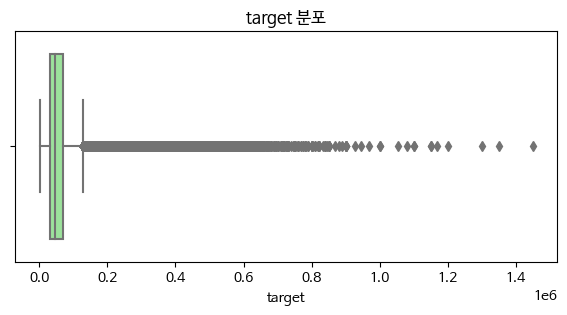

In [54]:
fig = plt.figure(figsize=(7, 3))
sns.boxplot(data = dt_train, x = 'target', color='lightgreen')
plt.title('target 분포')
plt.xlabel('target')
plt.show()

In [55]:
# 아웃라이어 제거
Q1 = dt_train['target'].quantile(0.25)
Q3 = dt_train['target'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

dt_train = dt_train[(dt_train['target'] >= lower_bound) & (dt_train['target'] <= upper_bound)]

# 라벨링

In [56]:
# '아파트명'열 라벨 인코딩

# 아파트명별 가격의 평균 내림차순 정렬
apt_price = dt_train.groupby('아파트명')['target'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

for i, a in enumerate(list(apt_price.index)):
    dt_train.loc[dt_train['아파트명'] == a, '아파트명'] = i # 라벨 인코딩
    dt_test.loc[dt_test['아파트명'] == a, '아파트명'] = i
apt_price = dt_train.groupby('아파트명')['target'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

변환전
 아파트명
잠실      86320.809675
파크리오    84479.406996
자이      77518.485439
더샵      75260.175052
롯데캐슬    71216.454732
Name: target, dtype: float64


변환후
 아파트명
0    86320.809675
1    84479.406996
2    77518.485439
3    75260.175052
4    71216.454732
Name: target, dtype: float64


In [57]:
# 'k-건설사(시공사)'열 라벨 인코딩

# 건설사별 가격의 평균 내림차순 정렬
apt_price = dt_train.groupby('k-건설사(시공사)')['target'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

for i, a in enumerate(list(apt_price.index)):
    dt_train.loc[dt_train['k-건설사(시공사)'] == a, 'k-건설사(시공사)'] = i # 라벨 인코딩
    dt_test.loc[dt_test['k-건설사(시공사)'] == a, 'k-건설사(시공사)'] = i
apt_price = dt_train.groupby('k-건설사(시공사)')['target'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

변환전
 k-건설사(시공사)
DL E&C    89750.000000
GS건설      81592.196346
롯데건설      70543.154603
포스코건설     66193.933828
삼성물산      63594.406541
Name: target, dtype: float64
변환후
 k-건설사(시공사)
0    89750.000000
1    81592.196346
2    70543.154603
3    66193.933828
4    63594.406541
Name: target, dtype: float64


In [58]:
# '동'열 라벨 인코딩
dong_price = dt_train.groupby('동')['target'].agg('mean').sort_values(ascending=False)
dong_price[:20]

동
압구정동    104767.689346
사직동      89459.088076
서빙고동     88192.902935
내곡동      88122.515152
반포동      86866.195483
잠실동      86764.744540
여의동      85892.503473
신원동      84030.629550
대치동      82993.376619
세곡동      82961.291774
이촌동      80741.962837
청담동      80540.751914
남영동      80130.813187
회현동      78863.581986
잠원동      78841.563627
도곡동      78704.830667
일원동      75969.169714
방배동      75942.210391
삼성동      75168.325465
아현동      74204.565129
Name: target, dtype: float64

In [59]:
# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행 - 477 it.
for i, d in tqdm(enumerate(list(dong_price.index)), total=len(dong_price)):
    dt_train.loc[dt_train['동'] == d, '동'] = i
    dt_test.loc[dt_test['동'] == d, '동'] = i
dt_train.head()

100%|██████████| 211/211 [00:12<00:00, 17.07it/s]


,계약날짜,전세가격지수,기준금리,구,동,k-건설사(시공사),건축년도,인구밀도 (명/㎢),전용면적(㎡),층,좌표X,좌표Y,아파트명,세대별주차대수,연식(거래일기준),target
0,20171208,92.7,1.5,강남구,20,13,1987,11824.116743,79.97,3,127.057210,37.476763,15,0.970370,30,124000.0
1,20171222,92.7,1.5,강남구,20,13,1987,11824.116743,79.97,4,127.057210,37.476763,15,0.970370,30,123500.0
2,20171228,92.7,1.5,강남구,20,13,1987,11824.116743,54.98,5,127.057210,37.476763,15,0.970370,30,91500.0
19,20171211,92.7,1.5,강남구,20,18,1982,11824.116743,42.55,3,127.058521,37.480002,30,0.000397,35,118000.0
20,20171212,92.7,1.5,강남구,20,18,1982,11824.116743,35.87,2,127.058521,37.480002,30,0.000397,35,123000.0


In [60]:
# '구'열 라벨 인코딩
gu_price = dt_train.groupby('구')['target'].agg('mean').sort_values(ascending=False)
gu_price[:20]

구
서초구     75434.801771
강남구     72955.425144
용산구     69824.385993
송파구     67374.657483
성동구     59794.782730
광진구     59703.991165
동작구     57366.131860
마포구     57296.690218
중구      56584.642711
양천구     52005.609013
강동구     51501.115167
영등포구    49906.139323
종로구     49016.758847
서대문구    46883.396901
성북구     44824.974779
동대문구    44308.848800
강서구     43341.094735
은평구     42171.677012
관악구     41836.461404
강북구     38302.698991
Name: target, dtype: float64

In [61]:
# 가격기준으로 구을 정렬한 리스트를 바탕으로 구에 대해 라벨 인코딩 진행 - 477 it.
for i, d in tqdm(enumerate(list(gu_price.index)), total=len(gu_price)):
    dt_train.loc[dt_train['구'] == d, '구'] = i
    dt_test.loc[dt_test['구'] == d, '구'] = i
dt_train.head()

100%|██████████| 25/25 [00:01<00:00, 18.19it/s]


,계약날짜,전세가격지수,기준금리,구,동,k-건설사(시공사),건축년도,인구밀도 (명/㎢),전용면적(㎡),층,좌표X,좌표Y,아파트명,세대별주차대수,연식(거래일기준),target
0,20171208,92.7,1.5,1,20,13,1987,11824.116743,79.97,3,127.057210,37.476763,15,0.970370,30,124000.0
1,20171222,92.7,1.5,1,20,13,1987,11824.116743,79.97,4,127.057210,37.476763,15,0.970370,30,123500.0
2,20171228,92.7,1.5,1,20,13,1987,11824.116743,54.98,5,127.057210,37.476763,15,0.970370,30,91500.0
19,20171211,92.7,1.5,1,20,18,1982,11824.116743,42.55,3,127.058521,37.480002,30,0.000397,35,118000.0
20,20171212,92.7,1.5,1,20,18,1982,11824.116743,35.87,2,127.058521,37.480002,30,0.000397,35,123000.0


In [62]:
dt_train['동'] = dt_train['동'].astype('int64')
dt_train['구'] = dt_train['구'].astype('int64')
dt_train['k-건설사(시공사)'] = dt_train['k-건설사(시공사)'].astype('int64')
dt_train['아파트명'] = dt_train['아파트명'].astype('int64')

dt_test['동'] = dt_test['동'].astype('int64')
dt_test['구'] = dt_test['구'].astype('int64')
dt_test['k-건설사(시공사)'] = dt_test['k-건설사(시공사)'].astype('int64')
dt_test['아파트명'] = dt_test['아파트명'].astype('int64')

dt_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1048253 entries, 0 to 1133640
Data columns (total 16 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   계약날짜        1048253 non-null  int64  
 1   전세가격지수      1048253 non-null  float64
 2   기준금리        1048253 non-null  float64
 3   구           1048253 non-null  int64  
 4   동           1048253 non-null  int64  
 5   k-건설사(시공사)  1048253 non-null  int64  
 6   건축년도        1048253 non-null  int64  
 7   인구밀도 (명/㎢)  1048253 non-null  float64
 8   전용면적(㎡)     1048253 non-null  float64
 9   층           1048253 non-null  int64  
 10  좌표X         803829 non-null   float64
 11  좌표Y         803829 non-null   float64
 12  아파트명        1048253 non-null  int64  
 13  세대별주차대수     1048253 non-null  float64
 14  연식(거래일기준)   1048253 non-null  int64  
 15  target      1048253 non-null  float64
dtypes: float64(8), int64(8)
memory usage: 136.0 MB


# 하이퍼파라미터 튜닝

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

In [65]:
dt_train = dt_train.sort_values(by='계약날짜')
cut = int(len(dt_train)*0.8)
h_train = dt_train[:cut]
h_valid = dt_train[cut:]

h_train_X = h_train.drop('target', axis=1)
h_train_y = h_train['target']
h_valid_X = h_valid.drop('target', axis=1)
h_valid_y = h_valid['target']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(838602, 15) (838602,) (209651, 15) (209651,)


In [66]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)

def objective(trial):
    dtrain = lgb.Dataset(h_train_X, label=h_train_y)
    dtest = lgb.Dataset(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'regression', # 회귀
        'verbose': -1,
        'metric': 'rmse', 
        'max_depth': trial.suggest_int('max_depth',3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-8, 1e-2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'subsample': trial.suggest_loguniform('subsample', 0.4, 1),
    }

    model = lgb.LGBMRegressor(**param)
    lgb_model = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)])
    rmse = RMSE(h_valid_y, lgb_model.predict(h_valid_X))
    return rmse
        
study_lgb = optuna.create_study(direction='minimize', sampler=sampler)
study_lgb.optimize(objective, n_trials=100)

[I 2024-01-25 06:35:29,018] A new study created in memory with name: no-name-1dc332b3-9fd9-4fba-9de8-50c4b150c782
[I 2024-01-25 06:35:48,880] Trial 0 finished with value: 34614.525075140096 and parameters: {'max_depth': 13, 'learning_rate': 1.3320229150659043e-08, 'n_estimators': 1938, 'min_child_samples': 76, 'subsample': 0.6315909175774905}. Best is trial 0 with value: 34614.525075140096.
[I 2024-01-25 06:36:10,797] Trial 1 finished with value: 34611.70652827142 and parameters: {'max_depth': 5, 'learning_rate': 1.5430400149097381e-07, 'n_estimators': 2306, 'min_child_samples': 21, 'subsample': 0.4337244827306443}. Best is trial 1 with value: 34611.70652827142.
[I 2024-01-25 06:36:12,205] Trial 2 finished with value: 31044.316007075722 and parameters: {'max_depth': 11, 'learning_rate': 0.005252427629146827, 'n_estimators': 111, 'min_child_samples': 54, 'subsample': 0.8422371309477078}. Best is trial 2 with value: 31044.316007075722.
[I 2024-01-25 06:36:22,139] Trial 3 finished with va

In [67]:
trial = study_lgb.best_trial
trial_params = trial.params
print('Best Trial: score {},\nparams {}'.format(trial.value, trial_params))

Best Trial: score 19432.8847997841,
params {'max_depth': 10, 'learning_rate': 0.009887684899909162, 'n_estimators': 2886, 'min_child_samples': 37, 'subsample': 0.5109117836469369}


In [68]:
trials_list = []
trials_dict ={'Idx': [], 'Values':[]}
idx = 0
trials = study_lgb.trials
for trial in trials:
    trials_dict['Idx'].append(idx)
    trials_dict['Values'].append(trial.value)
    idx += 1

df = pd.DataFrame(trials_dict)
df = df.sort_values(by='Values')
df.head(20)

,Idx,Values
97,97,19432.884800
85,85,19438.089003
93,93,19438.154528
99,99,19440.620772
96,96,19465.210492
94,94,19466.745741
43,43,19494.880274
86,86,19514.858214
72,72,19555.549214
69,69,19563.587318


In [69]:
train_X, train_y = dt_train.drop('target', axis=1), dt_train['target']

In [71]:
p01 = {'max_depth': 10, 'learning_rate': 0.009887684899909162, 'n_estimators': 2886, 'min_child_samples': 37, 'subsample': 0.5109117836469369}
p02 = {'max_depth': 6, 'learning_rate': 0.009962938283453814, 'n_estimators': 2664, 'min_child_samples': 40, 'subsample': 0.4687200059587954}
p03 = {'max_depth': 6, 'learning_rate': 0.009826873545012028, 'n_estimators': 2758, 'min_child_samples': 42, 'subsample': 0.5149294387977568}
p04 = {'max_depth': 10, 'learning_rate': 0.009724200279459135, 'n_estimators': 2904, 'min_child_samples': 27, 'subsample': 0.5121534385774202}
p05 = {'max_depth': 10, 'learning_rate': 0.009984531751511695, 'n_estimators': 2893, 'min_child_samples': 37, 'subsample': 0.48367719840675066}
p06 = {'max_depth': 10, 'learning_rate': 0.009826478297485551, 'n_estimators': 2788, 'min_child_samples': 41, 'subsample': 0.4692440871956808}
p07 = {'max_depth': 6, 'learning_rate': 0.008406637906950022, 'n_estimators': 2990, 'min_child_samples': 60, 'subsample': 0.7280921202136772}
p08 = {'max_depth': 6, 'learning_rate': 0.009980212943406178, 'n_estimators': 2481, 'min_child_samples': 30, 'subsample': 0.5048473426144797}
p09 = {'max_depth': 5, 'learning_rate': 0.009890613515206734, 'n_estimators': 2450, 'min_child_samples': 28, 'subsample': 0.42581713365034196}
p10 = {'max_depth': 5, 'learning_rate': 0.009852525805412283, 'n_estimators': 2409, 'min_child_samples': 25, 'subsample': 0.4957102059272771}

In [72]:
model = VotingRegressor([
    ('lgb_01', lgb.LGBMRegressor(**p01, random_state=10)),
    ('lgb_02', lgb.LGBMRegressor(**p02, random_state=10)),
    ('lgb_03', lgb.LGBMRegressor(**p03, random_state=10)),
    ('lgb_04', lgb.LGBMRegressor(**p04, random_state=10)),
    ('lgb_05', lgb.LGBMRegressor(**p05, random_state=10)),
    ('lgb_06', lgb.LGBMRegressor(**p06, random_state=10)),
    ('lgb_07', lgb.LGBMRegressor(**p07, random_state=10)),
    ('lgb_08', lgb.LGBMRegressor(**p08, random_state=10)),
    ('lgb_09', lgb.LGBMRegressor(**p09, random_state=10)),
    ('lgb_10', lgb.LGBMRegressor(**p10, random_state=10)),

])

model.fit(train_X, train_y)
final_pred = model.predict(dt_test)
final_pred

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005834 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2112
[LightGBM] [Info] Number of data points in the train set: 1048253, number of used features: 15
[LightGBM] [Info] Start training from score 48552.388465
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be b

array([126717.65942989, 146437.05832857, 130418.4908715 , ...,
        17096.75828497,  24951.93391456,  45444.42195253])

In [73]:
pd.DataFrame(final_pred.astype(int), columns=["target"]).to_csv('sub.csv', index=False)

In [ ]:
# 

- 추가로 변수 늘리기 + 아웃라이어 제거 해보기